In [1]:
import numpy as np
import pandas as pd
import random
import itertools
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, mean_squared_error, accuracy_score, recall_score, precision_score
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from azureml.core import Workspace, Dataset
from datetime import datetime
from sklearn.decomposition import TruncatedSVD
from scipy.spatial.distance import euclidean

In [2]:
subscription_id = '2e6847cc-33c9-446b-9825-d08536dbc664'
resource_group = 'dash'
workspace_name = 'dashproject'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='DASH')
data = dataset.to_pandas_dataframe()

In [3]:
def calculate_duration(date):
    if not isinstance(date, datetime):
        date_format = '%d-%m-%Y'
        date = datetime.strptime(str(date), date_format)
    current_year = datetime.now().year
    return current_year - date.year

def requires_support(value):
    return 0 if value == 'No Disability Support' else 1

def age(val):
    current_year = datetime.now().year
    return current_year-val

data['DurationInSystem'] = data['enterStateDate'].apply(calculate_duration)
data['RequiresSupport'] = data['disability_support'].apply(requires_support)
data['Age'] = data['yearOfBirth'].apply(age)
print(data)

     individualID  yearOfBirth  householdID CitizenshipStatus  yearOfDeath  \
0               1         1960          310       Worker_Visa         2012   
1               2         1992          510  Refugee_Claimant         2008   
2               3         1953          411  Refugee_Claimant         2014   
3               4         1957          548  Refugee_Claimant         2018   
4               5         1960          835  Refugee_Claimant         2012   
..            ...          ...          ...               ...          ...   
995           996         1987          880       Worker_Visa         2021   
996           997         1951          537           Refugee         2022   
997           998         1974          348  Refugee_Claimant         2016   
998           999         1954          490       Worker_Visa         2018   
999          1000         1979          362       Worker_Visa         2015   

     GenderType            diverseStatus  applicationID  regist

In [4]:
unique_citizenship_statuses = data['CitizenshipStatus'].unique()
unique_diverse_statuses = data['diverseStatus'].unique()
unique_gender_types = data['GenderType'].unique()

percentage_dict = {}

for citizenship_status, diverse_status, gender_type in itertools.product(
    unique_citizenship_statuses, unique_diverse_statuses, unique_gender_types):
    percentage_dict[(citizenship_status, diverse_status, gender_type)] = random.randint(65, 85)

In [5]:
def decide_action_permutation(row):
    if row['state'] == 'Awaiting':
        if row['DurationInSystem'] < 10:
            return 'Stay'
        elif 10 <= row['DurationInSystem'] < 25:
            percentage = percentage_dict[(row['CitizenshipStatus'], row['diverseStatus'], row['GenderType'])]
            return 'Stay' if random.randint(1, 100) <= percentage else 'Withdraw'
        elif 25 <= row['DurationInSystem'] < 30:
            if row['diverseStatus'] not in ['Black', 'Visible Minority']:
                return 'Stay' if random.randint(1, 100) <= 55 else 'Withdraw'
            else:
                return 'Withdraw'
        elif row['DurationInSystem'] >= 30:
            return 'Stay' if random.randint(1, 100) <= 20 else 'Withdraw'
    elif row['state'] == 'Aftercare':
        return 'Stay' if random.randint(1, 100) <= 90 else 'Withdraw'
    elif row['state'] == 'Moveout':
        return 'Withdraw'
    elif row['state'] == 'Allocated_Living':
        return 'Stay'
    else:
        return 'Stay' if random.randint(1, 100) <= 50 else 'Withdraw'

data['StayOrWithdraw'] = data.apply(decide_action_permutation, axis=1)

In [6]:
data.to_csv('Final_Data.csv', index=False)

## Mortality Rate Prediction

In [8]:
data['ageAtDeath'] = data['yearOfDeath'] - data['yearOfBirth']
features = data[['CitizenshipStatus', 'GenderType', 'diverseStatus', 'yearOfBirth']]
target = data['ageAtDeath']

In [9]:
encoder = OneHotEncoder()
features_encoded = encoder.fit_transform(features.select_dtypes(include=['object']))
features_encoded_df = pd.DataFrame(features_encoded.toarray(), columns=encoder.get_feature_names_out())
features_encoded_df['yearOfBirth'] = features['yearOfBirth'].values

In [10]:
X_train, X_test, y_train, y_test = train_test_split(features_encoded_df, target, test_size=0.2, random_state=0)

In [11]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [12]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(rmse)

5.0474482185439


The linear regression model for predicting age at death has a Root Mean Squared Error (RMSE) of approximately 5 years. This metric indicates the average deviation of the predicted ages at death from the actual values in the test dataset.

## Wheelchair Needs Analysis and Trends in Future Years

In [13]:
wheelchair_needs = data['disability_support'].str.contains('Wheelchair', case=False).sum()
print("Number of People who reqire Wheelchair as a Disability Support = ", wheelchair_needs)

Number of People who reqire Wheelchair as a Disability Support =  127


In [14]:
wheelchair_accessible_units = data['wheelchairAccessible'].sum()
print("Number of Units Currently having WheelChair Accessibility = ", wheelchair_accessible_units)

Number of Units Currently having WheelChair Accessibility =  268


In [15]:
current_year = 2023
data['Age_in_5_years'] = data['Age'] + 5
data['Age_in_10_years'] = data['Age'] + 10
data['Age_in_15_years'] = data['Age'] + 15
data['Age_in_20_years'] = data['Age'] + 20

In [34]:
percentage_needing_wheelchair = 0.75
age_threshold = 65


estimated_wheelchair_needs_5_years = (data['Age_in_5_years'] >= age_threshold).sum() * percentage_needing_wheelchair
estimated_wheelchair_needs_10_years = (data['Age_in_10_years'] >= age_threshold).sum() * percentage_needing_wheelchair
estimated_wheelchair_needs_15_years = (data['Age_in_15_years'] >= age_threshold).sum() * percentage_needing_wheelchair
estimated_wheelchair_needs_20_years = (data['Age_in_20_years'] >= age_threshold).sum() * percentage_needing_wheelchair

additional_units_needed_5_years = int(estimated_wheelchair_needs_5_years) - wheelchair_accessible_units
additional_units_needed_10_years = int(estimated_wheelchair_needs_10_years) - wheelchair_accessible_units
additional_units_needed_15_years = int(estimated_wheelchair_needs_15_years) - wheelchair_accessible_units
additional_units_needed_20_years = int(estimated_wheelchair_needs_20_years) - wheelchair_accessible_units

print("Estimated Number of People Needing Wheelchair Support in 5 Years:", round(estimated_wheelchair_needs_5_years))
print("Estimated Number of units required with Wheelchair in 5 Years from Now: ", additional_units_needed_5_years)
print("Estimated Number of People Needing Wheelchair Support in 10 Years:", round(estimated_wheelchair_needs_10_years))
print("Estimated Number of units required with Wheelchair in 10 Years from Now: ", additional_units_needed_10_years)
print("Estimated Number of People Needing Wheelchair Support in 15 Years:", round(estimated_wheelchair_needs_15_years))
print("Estimated Number of units required with Wheelchair in 15 Years from Now: ", additional_units_needed_15_years)
print("Estimated Number of People Needing Wheelchair Support in 20 Years:", round(estimated_wheelchair_needs_20_years))
print("Estimated Number of units required with Wheelchair in 20 Years from Now: ", additional_units_needed_20_years)


Estimated Number of People Needing Wheelchair Support in 5 Years: 182
Estimated Number of units required with Wheelchair in 5 Years from Now:  -87
Estimated Number of People Needing Wheelchair Support in 10 Years: 259
Estimated Number of units required with Wheelchair in 10 Years from Now:  -10
Estimated Number of People Needing Wheelchair Support in 15 Years: 313
Estimated Number of units required with Wheelchair in 15 Years from Now:  44
Estimated Number of People Needing Wheelchair Support in 20 Years: 388
Estimated Number of units required with Wheelchair in 20 Years from Now:  119


In [17]:
years = [5, 10, 15, 20]
total_population = data.shape[0]
estimated_needs_percent = [
    (estimated_wheelchair_needs_5_years / total_population) * 100,
    (estimated_wheelchair_needs_10_years / total_population) * 100,
    (estimated_wheelchair_needs_15_years / total_population) * 100,
    (estimated_wheelchair_needs_20_years / total_population) * 100
]

additional_units_needed = [
    additional_units_needed_5_years,
    additional_units_needed_10_years,
    additional_units_needed_15_years,
    additional_units_needed_20_years
]

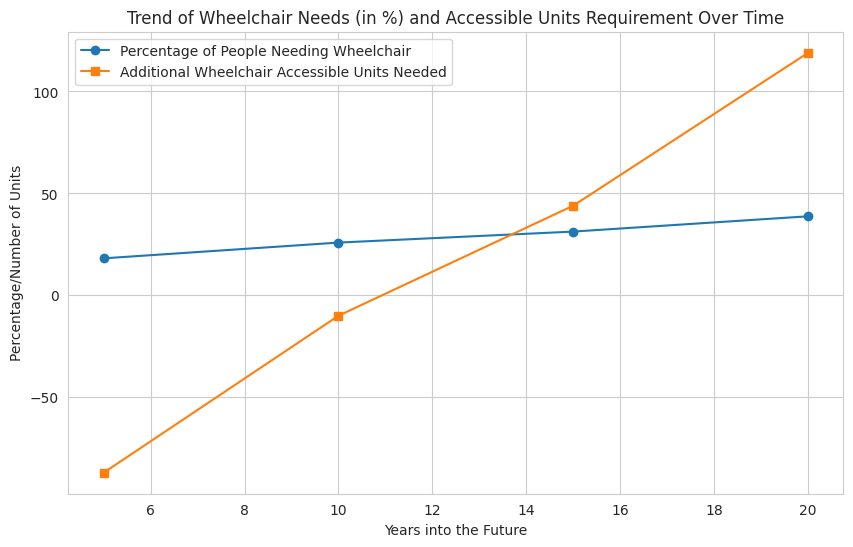

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(years, estimated_needs_percent, label='Percentage of People Needing Wheelchair', marker='o')
plt.plot(years, additional_units_needed, label='Additional Wheelchair Accessible Units Needed', marker='s')
plt.xlabel('Years into the Future')
plt.ylabel('Percentage/Number of Units')
plt.title('Trend of Wheelchair Needs (in %) and Accessible Units Requirement Over Time')
plt.legend()
plt.grid(True)
plt.show()

## Disability Support Requirement Analysis and Trends in Future Years

In [19]:
current_no_support = data['RequiresSupport'].value_counts().get(0, 0)
current_support = data['RequiresSupport'].value_counts().get(1, 0)
print("Current Number of Individuals who do not require Disability Support:", current_no_support)
print("Current Number of Individuals who require Disability Support:", current_support)

Current Number of Individuals who do not require Disability Support: 370
Current Number of Individuals who require Disability Support: 630


In [20]:
percentages_transition_to_support = {1: 0.02, 5: 0.07, 10: 0.12, 15: 0.15, 20: 0.18}
percentage_transition_away_from_support_10_years = 0.05

results = {}
for years, percentage_increase in percentages_transition_to_support.items():
    initial_support_needs_this_year = current_support
    additional_needs = int(current_no_support * percentage_increase)
    
    if years == 10:
        reduction_in_needs = int(current_support * percentage_transition_away_from_support_10_years)
        additional_needs -= reduction_in_needs

    current_support += additional_needs

    results[years] = {
        "Initial Support Needs": initial_support_needs_this_year,
        "Additional Support Needs": additional_needs,
        "Updated Total Support Needs": current_support
    }

In [21]:
for years, i in results.items():
    print(f"After {years} year period:")
    print(f"Intial Support Needs: {i['Initial Support Needs']}")
    print(f"Additional Support Needs: {i['Additional Support Needs']}")
    print(f"Updated Total Support Needs: {i['Updated Total Support Needs']}")
    print()

After 1 year period:
Intial Support Needs: 630
Additional Support Needs: 7
Updated Total Support Needs: 637

After 5 year period:
Intial Support Needs: 637
Additional Support Needs: 25
Updated Total Support Needs: 662

After 10 year period:
Intial Support Needs: 662
Additional Support Needs: 11
Updated Total Support Needs: 673

After 15 year period:
Intial Support Needs: 673
Additional Support Needs: 55
Updated Total Support Needs: 728

After 20 year period:
Intial Support Needs: 728
Additional Support Needs: 66
Updated Total Support Needs: 794



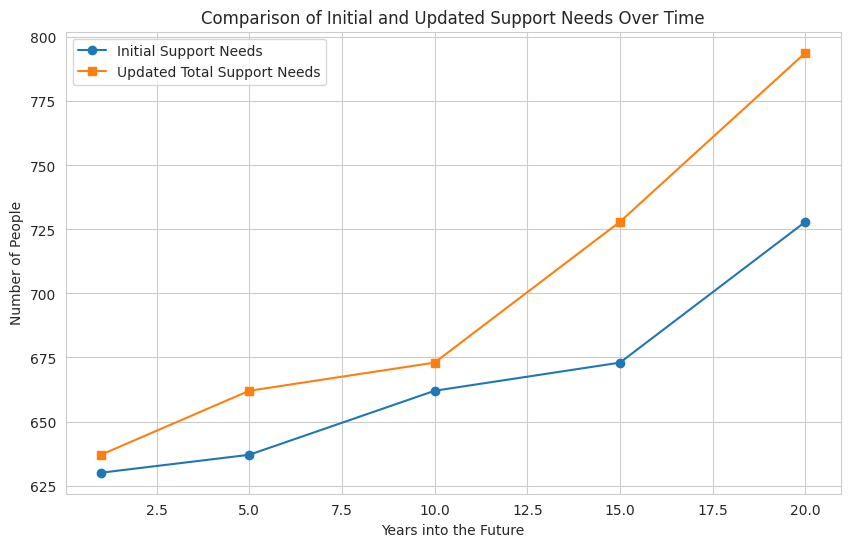

In [22]:
years = list(results.keys())
initial_needs = [i['Initial Support Needs'] for i in results.values()]
updated_needs = [i['Updated Total Support Needs'] for i in results.values()]

plt.figure(figsize=(10, 6))
plt.plot(years, initial_needs, label='Initial Support Needs', marker='o')
plt.plot(years, updated_needs, label='Updated Total Support Needs', marker='s')

plt.xlabel('Years into the Future')
plt.ylabel('Number of People')
plt.title('Comparison of Initial and Updated Support Needs Over Time')
plt.legend()
plt.grid(True)
plt.show()

## Housing Preferences and Mortality Rates Analysis

In [23]:
housing_year_variable = 'yearOfDeath'

housing_preferences = data.groupby([housing_year_variable, 'unitType']).size().unstack().fillna(0)
mortality_rates = data['yearOfDeath'].value_counts().sort_index()
housing_preferences.head(), mortality_rates.head()

(unitType     Affordable_Housing  Hotel  Market_Rental  Shelter  Social_Housing
 yearOfDeath                                                                   
 2006                         14      9             11        6              20
 2007                         12      7             12        7              20
 2008                         18      7             15        7              15
 2009                          8      5             15        5              15
 2010                         13      5             15        2              16,
 yearOfDeath
 2006    60
 2007    58
 2008    62
 2009    48
 2010    51
 Name: count, dtype: int64)

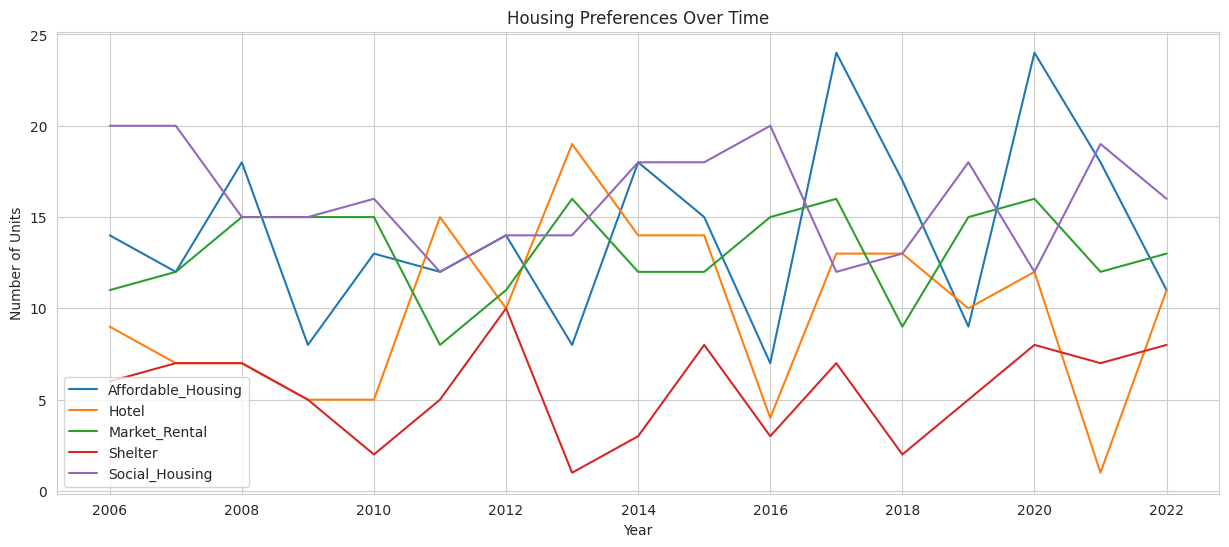

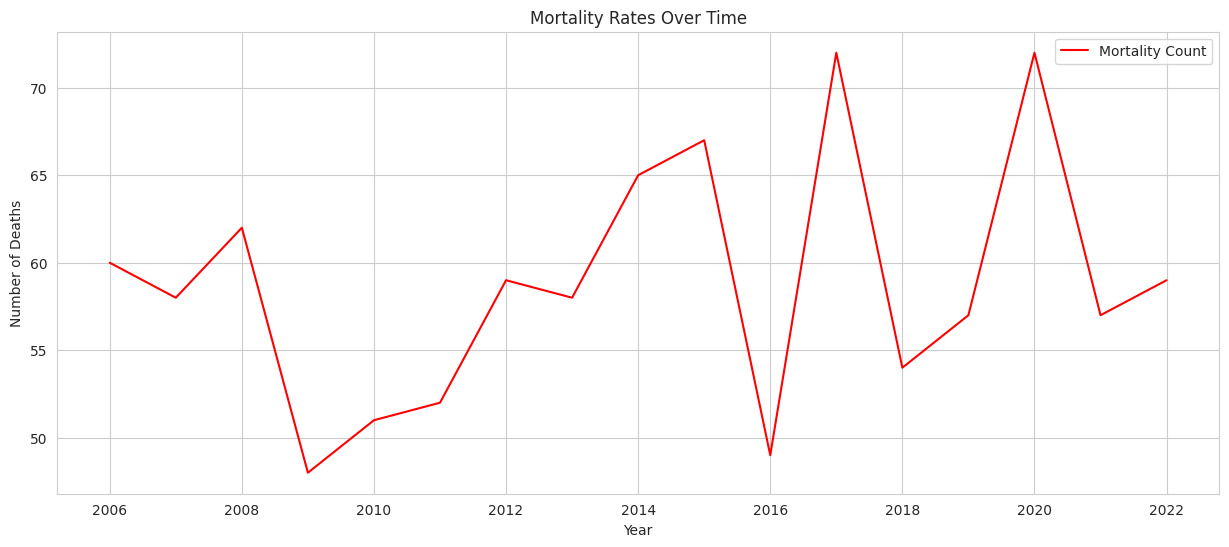

In [24]:
plt.figure(figsize=(15, 6))
plt.title('Housing Preferences Over Time')
for unit_type in housing_preferences.columns:
    plt.plot(housing_preferences[unit_type], label=unit_type)
plt.xlabel('Year')
plt.ylabel('Number of Units')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(15, 6))
plt.title('Mortality Rates Over Time')
plt.plot(mortality_rates, label='Mortality Count', color='red')
plt.xlabel('Year')
plt.ylabel('Number of Deaths')
plt.legend()
plt.grid(True)
plt.show()

## Supervised Machine Learning - Predicting Stay or Withdrawal

In [25]:
data_cleaned = data.drop(['individualID', 'householdID', 'applicationID', 
                          'registryID', 'adress', 'city', 'provience', 'postalCode', 'ageAtDeath', 'housingUnitID', 'enterStateDate', 'Age_in_5_years', 'Age_in_10_years', 'Age_in_15_years', 'Age_in_20_years'], axis=1)


In [26]:
data_cleaned

,yearOfBirth,CitizenshipStatus,yearOfDeath,GenderType,diverseStatus,state,BeforeSettlePlaceType,AfterMoveOutPlaceType,unitType,numberOfBedroom,wheelchairAccessible,disability_support,DurationInSystem,RequiresSupport,Age,StayOrWithdraw
0,1960,Worker_Visa,2012,Non-Binary,Indigenous_FirstNations,Allocated_Living,None,Family_House,Social_Housing,2,False,No Disability Support,8,0,63,Stay
1,1992,Refugee_Claimant,2008,Female,Visible_Minority,Allocated_Living,None,Own_House,Shelter,4,False,Wheelchair,25,1,31,Stay
2,1953,Refugee_Claimant,2014,Female,Visible_Minority,Awaiting,None,None,Affordable_Housing,2,False,Wheelchair,29,1,70,Stay
3,1957,Refugee_Claimant,2018,Male,Visible_Minority,Awaiting,Prison,None,Social_Housing,1,False,Hearing,13,1,66,Stay
4,1960,Refugee_Claimant,2012,Female,Visible_Minority,Aftercare,Prison,Own_House,Affordable_Housing,2,True,Service Dog,33,1,63,Stay
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1987,Worker_Visa,2021,Other,Indigenous_FirstNations,Awaiting,None,Family_House,Affordable_Housing,3,False,No Disability Support,16,0,36,Stay
996,1951,Refugee,2022,Male,Black,Allocated_Living,Own_House,None,Affordable_Housing,1,False,Mental Health | Wheelchair,13,1,72,Stay
997,1974,Refugee_Claimant,2016,Female,Visible_Minority,Allocated_Living,Own_House,None,Market_Rental,2,False,Wheelchair,15,1,49,Stay
998,1954,Worker_Visa,2018,Other,Indigenous_FirstNations,Allocated_Living,None,Family_House,Social_Housing,3,False,Visual,30,1,69,Stay


In [27]:
for column in data_cleaned.columns:
    if data_cleaned[column].dtype == 'object':
        data_cleaned[column] = data_cleaned[column].fillna(data_cleaned[column].mode()[0])
    else:
        data_cleaned[column] = data_cleaned[column].fillna(data_cleaned[column].mean())

In [28]:
numerical_cols = data_cleaned.select_dtypes(include=['number']).columns
data_clean = data_cleaned.dropna()

In [29]:
label_encoders = {}
for column in data_cleaned.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    data_cleaned[column] = label_encoders[column].fit_transform(data_cleaned[column])

In [30]:
X_tree = data_clean[numerical_cols]
y_tree = data_clean['StayOrWithdraw']

In [31]:
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X_tree, y_tree, test_size=0.2, random_state=0)

In [32]:
X_train_tree

,yearOfBirth,yearOfDeath,numberOfBedroom,DurationInSystem,RequiresSupport,Age
687,1972,2015,2,29,1,51
500,1969,2012,1,19,1,54
332,1962,2022,3,33,1,61
979,1997,2011,1,0,1,26
817,1999,2007,5,33,1,24
...,...,...,...,...,...,...
835,1988,2007,5,28,0,35
192,1986,2007,4,26,1,37
629,2001,2012,4,3,0,22
559,1978,2006,5,15,1,45


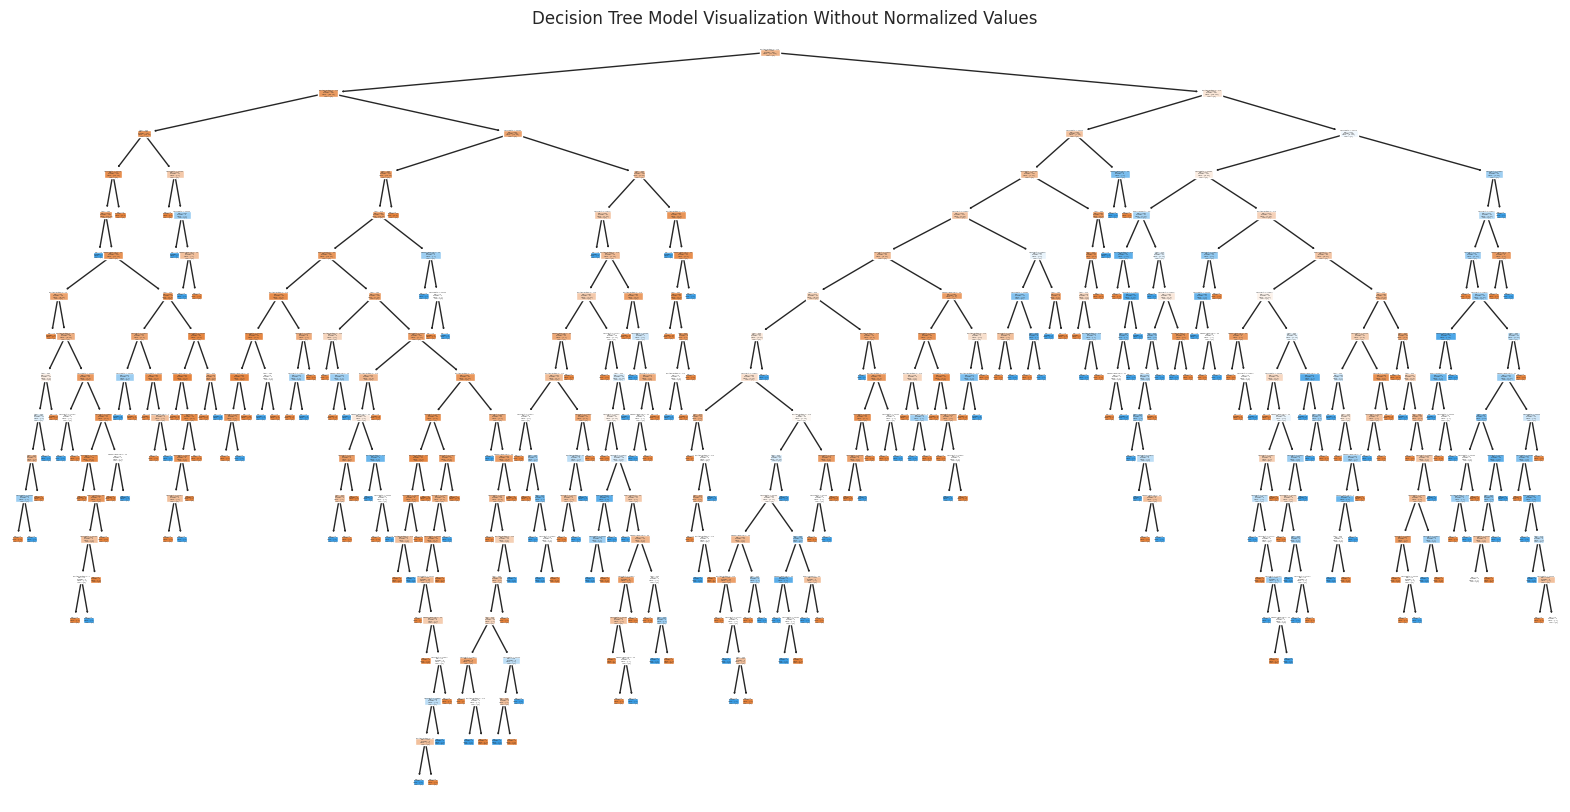

In [33]:
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train_tree, y_train_tree)

plt.figure(figsize=(20,10))
plot_tree(dt_classifier, filled=True, feature_names=X_tree.columns, class_names=True)
plt.title('Decision Tree Model Visualization Without Normalized Values')
plt.savefig('decision_tree_2.png', dpi=500)
plt.show()



In [34]:
X = data_cleaned.drop('StayOrWithdraw', axis=1)
y = data_cleaned['StayOrWithdraw']

In [35]:
label_encoder_y = LabelEncoder()
y = label_encoder_y.fit_transform(y)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=42)

In [37]:
X_test

,yearOfBirth,CitizenshipStatus,yearOfDeath,GenderType,diverseStatus,state,BeforeSettlePlaceType,AfterMoveOutPlaceType,unitType,numberOfBedroom,wheelchairAccessible,disability_support,DurationInSystem,RequiresSupport,Age
521,1961,4,2014,1,5,1,0,4,0,3,False,49,32,0,62
737,1972,0,2015,0,4,2,0,0,1,5,False,49,1,0,51
740,1974,1,2008,3,2,2,2,3,0,5,False,50,31,1,49
660,1999,1,2019,0,2,2,2,1,1,5,False,53,11,1,24
411,1961,2,2008,2,3,0,2,4,0,5,False,49,33,0,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,1975,0,2012,0,4,0,2,3,0,1,False,1,27,1,48
332,1962,4,2022,2,5,3,2,3,0,3,False,54,33,1,61
208,1994,0,2010,1,4,3,1,3,4,5,True,56,10,1,29
613,1992,3,2017,0,6,2,1,1,0,3,True,49,33,0,31


In [38]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [39]:
selector = SelectKBest(f_classif, k=10)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

In [40]:
selected_features = X.columns[selector.get_support()]
print("Best 10 Features Selected: ", selected_features.tolist())

Best 10 Features Selected:  ['yearOfBirth', 'yearOfDeath', 'GenderType', 'diverseStatus', 'state', 'BeforeSettlePlaceType', 'numberOfBedroom', 'disability_support', 'DurationInSystem', 'Age']


In [41]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
decision_tree = DecisionTreeClassifier(splitter = 'random', random_state=42)
svc = SVC(kernel = 'poly', random_state=42)
gradient_boosting = GradientBoostingClassifier(learning_rate=0.1, random_state=42)
logistic_regression = LogisticRegression(max_iter=2000, random_state=42)

In [42]:
pipelines = {
    "Random Forest": Pipeline([('feature_selection', selector), ('model', random_forest)]),
    "Decision Tree": Pipeline([('feature_selection', selector), ('model', decision_tree)]),
    "SVC": Pipeline([('feature_selection', selector), ('model', svc)]),
    "Gradient Boosting": Pipeline([('feature_selection', selector), ('model', gradient_boosting)]),
    "Logistic Regression": Pipeline([('feature_selection', selector), ('model', logistic_regression)])
}

In [43]:
cv_scores_with_feature_selection = {
    model_name: cross_val_score(pipeline, X_train_scaled, y_train, cv=5).mean()
    for model_name, pipeline in pipelines.items()
}
print(cv_scores_with_feature_selection)

{'Random Forest': 0.78625, 'Decision Tree': 0.75, 'SVC': 0.7175, 'Gradient Boosting': 0.79375, 'Logistic Regression': 0.7649999999999999}


In [44]:
random_forest.fit(X_train_selected, y_train)
decision_tree.fit(X_train_selected, y_train)
svc.fit(X_train_selected, y_train)
gradient_boosting.fit(X_train_selected, y_train)
logistic_regression.fit(X_train_selected, y_train)

LogisticRegression(max_iter=2000, random_state=42)

In [45]:
rf_pred = random_forest.predict(X_test_selected)
dt_pred = decision_tree.predict(X_test_selected)
svc_pred = svc.predict(X_test_selected)
gb_pred = gradient_boosting.predict(X_test_selected)
lr_pred = logistic_regression.predict(X_test_selected)


In [46]:
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred,pos_label=0)
rf_precison = precision_score(y_test, rf_pred,pos_label=0)

dt_accuracy = accuracy_score(y_test, dt_pred)
dt_recall = recall_score(y_test, dt_pred,pos_label=0)
dt_precison = precision_score(y_test, dt_pred,pos_label=0)

svc_accuracy = accuracy_score(y_test, svc_pred)
svc_recall = recall_score(y_test, svc_pred,pos_label=0)
svc_precison = precision_score(y_test, svc_pred,pos_label=0)

gb_accuracy = accuracy_score(y_test, gb_pred)
gb_recall = recall_score(y_test, gb_pred,pos_label=0)
gb_precison = precision_score(y_test, gb_pred,pos_label=0)

lr_accuracy = accuracy_score(y_test, lr_pred)
lr_recall = recall_score(y_test, lr_pred,pos_label=0)
lr_precison = precision_score(y_test, lr_pred,pos_label=0)


In [47]:
rf_report = classification_report(y_test, rf_pred)
dt_report = classification_report(y_test, dt_pred)
svc_report = classification_report(y_test, svc_pred)
gb_report = classification_report(y_test, gb_pred)
lr_report = classification_report(y_test, lr_pred)
print("Random Forest Report: ")
print()
print(rf_report)
print('-------------------------------------------------------')
print("Decision Tree Report: ")
print()
print(dt_report)
print('-------------------------------------------------------')
print("SVM Report: ")
print()
print(svc_report)
print('-------------------------------------------------------')
print("Gradient Boosting Report: ")
print()
print(gb_report)
print('-------------------------------------------------------')
print("Logistic Regression Report: ")
print()
print(lr_report)

Random Forest Report: 

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       143
           1       0.65      0.46      0.54        57

    accuracy                           0.78       200
   macro avg       0.73      0.68      0.69       200
weighted avg       0.76      0.78      0.76       200

-------------------------------------------------------
Decision Tree Report: 

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       143
           1       0.60      0.51      0.55        57

    accuracy                           0.77       200
   macro avg       0.71      0.69      0.70       200
weighted avg       0.76      0.77      0.76       200

-------------------------------------------------------
SVM Report: 

              precision    recall  f1-score   support

           0       0.77      0.94      0.85       143
           1       0.67      0.32      0.43        57

    accu

In [48]:
class_names_str = [str(cls) for cls in label_encoder_y.classes_]

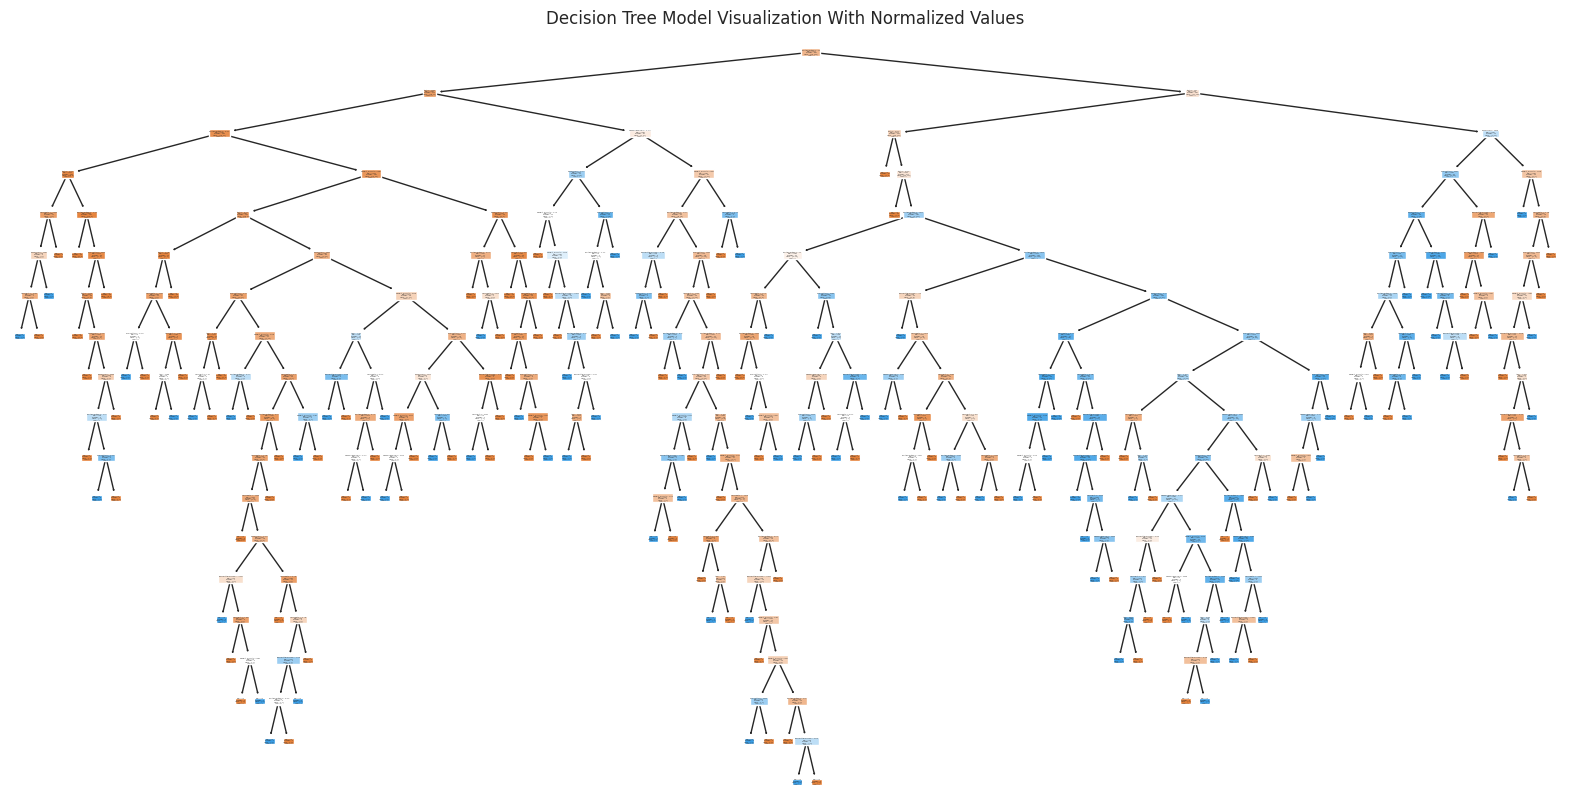

In [49]:
plt.figure(figsize=(20,10))
plot_tree(decision_tree, filled=True, feature_names=selected_features, class_names=class_names_str)
plt.title('Decision Tree Model Visualization With Normalized Values')
plt.savefig('decision_tree.png', dpi=500)
plt.show()


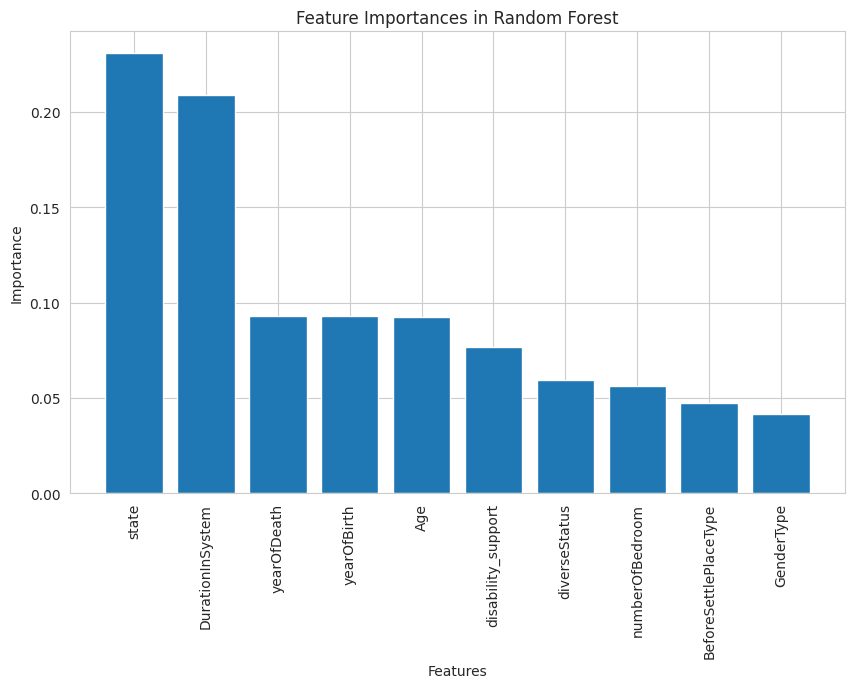

In [50]:
plt.figure(figsize=(10,6))
importances = random_forest.feature_importances_
indices = np.argsort(importances)[::-1]
plt.title('Feature Importances in Random Forest')
plt.bar(range(X_train_selected.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train_selected.shape[1]), selected_features[indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [51]:
X_test_with_predictions = X_test.copy()
X_test_with_predictions['Predicted'] = gb_pred

In [52]:
example_stay = X_test_with_predictions[X_test_with_predictions['Predicted'] == 0].iloc[0]
example_withdraw = X_test_with_predictions[X_test_with_predictions['Predicted'] == 1].iloc[0]

print(example_stay)
print(example_withdraw)

yearOfBirth               1961
CitizenshipStatus            4
yearOfDeath               2014
GenderType                   1
diverseStatus                5
state                        1
BeforeSettlePlaceType        0
AfterMoveOutPlaceType        4
unitType                     0
numberOfBedroom              3
wheelchairAccessible     False
disability_support          49
DurationInSystem            32
RequiresSupport              0
Age                         62
Predicted                    0
Name: 521, dtype: object
yearOfBirth               1979
CitizenshipStatus            0
yearOfDeath               2013
GenderType                   2
diverseStatus                4
state                        3
BeforeSettlePlaceType        0
AfterMoveOutPlaceType        0
unitType                     1
numberOfBedroom              1
wheelchairAccessible     False
disability_support          49
DurationInSystem            33
RequiresSupport              0
Age                         44
Predicted     

## Unsupervised Machine Learning

In [53]:
X = data.drop(['individualID', 'householdID', 'applicationID', 
                          'registryID','adress', 'postalCode', 'housingUnitID', 'Age_in_5_years', 'Age_in_10_years', 'Age_in_15_years', 'Age_in_20_years', 'ageAtDeath', 'StayOrWithdraw'], axis=1)
print(X)

     yearOfBirth CitizenshipStatus  yearOfDeath  GenderType     diverseStatus  \
0           1960       Worker_Visa         2012      Female     First_Nations   
1           1992  Refugee_Claimant         2008        Male  Visible_Minority   
2           1953  Refugee_Claimant         2014        Male  Visible_Minority   
3           1957  Refugee_Claimant         2018  Non-Binary  Visible_Minority   
4           1960  Refugee_Claimant         2012      Female  Visible_Minority   
..           ...               ...          ...         ...               ...   
995         1987       Worker_Visa         2021        Male     First_Nations   
996         1951           Refugee         2022        Male             Black   
997         1974  Refugee_Claimant         2016      Female  Visible_Minority   
998         1954       Worker_Visa         2018      Female     First_Nations   
999         1979       Worker_Visa         2015        Male     First_Nations   

                state enter

In [54]:
categorical_cols = [cname for cname in X.columns if 
                    X[cname].dtype == "object"]

In [55]:
numerical_cols = [cname for cname in X.columns if 
                  X[cname].dtype in ['int64', 'float64']]

In [56]:
numerical_transformer = SimpleImputer(strategy='mean')

In [57]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [58]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [59]:
X_preprocessed = preprocessor.fit_transform(X)

In [60]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init=10)
kmeans.fit(X_preprocessed)
labels = kmeans.labels_
X['Cluster'] = labels
X.head()

,yearOfBirth,CitizenshipStatus,yearOfDeath,GenderType,diverseStatus,state,enterStateDate,BeforeSettlePlaceType,AfterMoveOutPlaceType,unitType,city,numberOfBedroom,provience,wheelchairAccessible,disability_support,DurationInSystem,RequiresSupport,Age,Cluster
0,1960,Worker_Visa,2012,Female,First_Nations,Allocated_Living,2015-05-24,None,Family_House,Social_Housing,Stephenville,2,Newfoundland and Labrador,False,No Disability Support,8,0,63,1
1,1992,Refugee_Claimant,2008,Male,Visible_Minority,Allocated_Living,1998-02-16,None,Own_House,Shelter,St. Albert,4,Alberta,False,Wheelchair,25,1,31,0
2,1953,Refugee_Claimant,2014,Male,Visible_Minority,Awaiting,1994-07-25,None,None,Affordable_Housing,Brandon,2,Manitoba,False,Wheelchair,29,1,70,1
3,1957,Refugee_Claimant,2018,Non-Binary,Visible_Minority,Awaiting,2010-05-21,Prison,None,Social_Housing,Richmond,1,British Columbia,False,Hearing,13,1,66,1
4,1960,Refugee_Claimant,2012,Female,Visible_Minority,Aftercare,1990-01-05,Prison,Own_House,Affordable_Housing,Yorkton,2,Saskatchewan,True,Service Dog,33,1,63,1


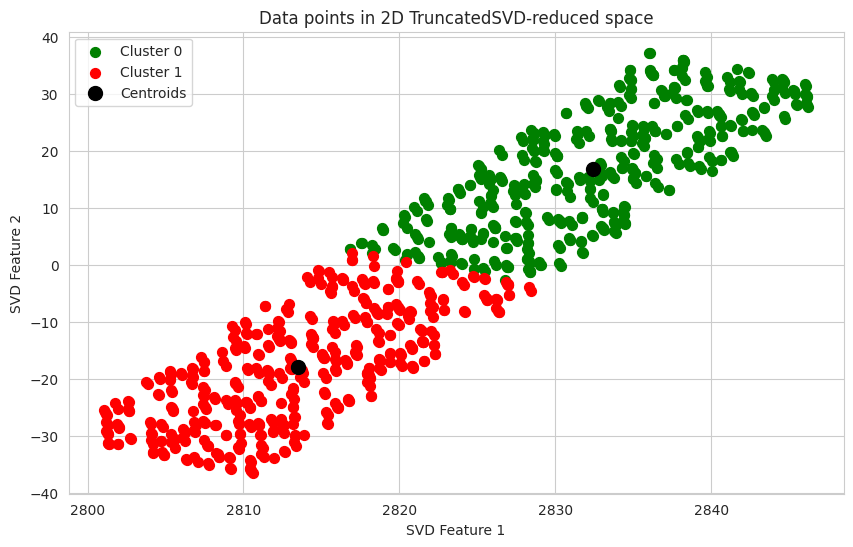

In [61]:
svd = TruncatedSVD(n_components=2)
reduced_data = svd.fit_transform(X_preprocessed)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[labels == 0, 0], reduced_data[labels == 0, 1], s=50, c='green', label='Cluster 0')
plt.scatter(reduced_data[labels == 1, 0], reduced_data[labels == 1, 1], s=50, c='red', label='Cluster 1')

centroids = svd.transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], s=100, c='black', label='Centroids')

plt.title('Data points in 2D TruncatedSVD-reduced space')
plt.xlabel('SVD Feature 1')
plt.ylabel('SVD Feature 2')
plt.legend()
plt.show()

In [62]:
data_with_clusters = data.copy()
data_with_clusters['Cluster'] = labels
cluster_distribution = data_with_clusters.groupby('Cluster')['StayOrWithdraw'].value_counts().unstack()

print(cluster_distribution)

StayOrWithdraw  Stay  Withdraw
Cluster                       
0                373       139
1                335       153


In [63]:
new_data = pd.read_excel("exampleforkmeans.xlsx")
new_data = new_data.drop(['individualID', 'householdID', 'applicationID', 
                          'registryID','adress', 'postalCode', 'housingUnitID', 'Age_in_5_years', 'Age_in_10_years', 'Age_in_15_years', 'Age_in_20_years', 'StayOrWithdraw'], axis=1)
new_data.head()

,yearOfBirth,CitizenshipStatus,yearOfDeath,GenderType,diverseStatus,state,enterStateDate,BeforeSettlePlaceType,AfterMoveOutPlaceType,unitType,city,numberOfBedroom,provience,wheelchairAccessible,disability_support,DurationInSystem,RequiresSupport,Age
0,1973,Citizen_BornInCanada,2018,Other,NaN,Move_Out,1990-03-20,NaN,Family_House,Social_Housing,Mount Pearl,1,Newfoundland and Labrador,0,Wheelchair,33,1,50
1,1995,Student_Visa,2008,Non-Binary,Visibile_Minority,Move_Out,2013-08-04,Own_House,Friend_House,Social_Housing,Montreal,2,Quebec,1,Hearing | Wheelchair,10,1,28


Distance between Example 1 and Centroid 0: 26.553968343292244
Distance between Example 1 and Centroid 1: 13.73782065654134
Distance between Example 2 and Centroid 0: 7.45944300498216
Distance between Example 2 and Centroid 1: 45.412079621159506


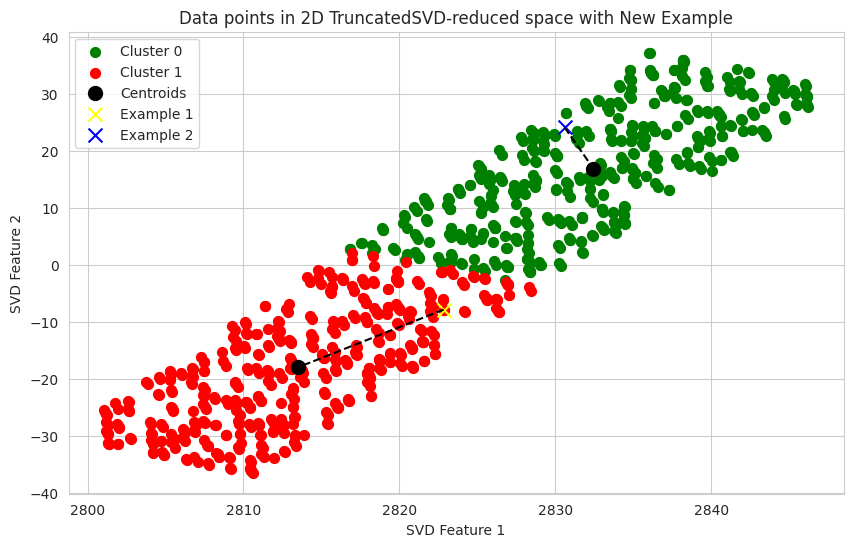

In [64]:
new_data_preprocessed = preprocessor.transform(new_data)  
predictions = kmeans.predict(new_data_preprocessed)
new_data_reduced = svd.transform(new_data_preprocessed) 

plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[labels == 0, 0], reduced_data[labels == 0, 1], s=50, c='green', label='Cluster 0')
plt.scatter(reduced_data[labels == 1, 0], reduced_data[labels == 1, 1], s=50, c='red', label='Cluster 1')
centroids = svd.transform(kmeans.cluster_centers_)
distance_to_centroid_0 = euclidean(new_data_reduced[0], centroids[0])
distance_to_centroid_1 = euclidean(new_data_reduced[0], centroids[1])

print("Distance between Example 1 and Centroid 0:", distance_to_centroid_0)
print("Distance between Example 1 and Centroid 1:", distance_to_centroid_1)

distance_to_centroid_0 = euclidean(new_data_reduced[1], centroids[0])
distance_to_centroid_1 = euclidean(new_data_reduced[1], centroids[1])

print("Distance between Example 2 and Centroid 0:", distance_to_centroid_0)
print("Distance between Example 2 and Centroid 1:", distance_to_centroid_1)

plt.scatter(centroids[:, 0], centroids[:, 1], s=100, c='black', label='Centroids')

plt.scatter(new_data_reduced[0, 0], new_data_reduced[0, 1], s=100, c='yellow', marker='x', label='Example 1')
plt.plot([new_data_reduced[0, 0], centroids[predictions[0], 0]], [new_data_reduced[0, 1], centroids[predictions[0], 1]], 'k--')
plt.scatter(new_data_reduced[1, 0], new_data_reduced[1, 1], s=100, c='blue', marker='x', label='Example 2')
plt.plot([new_data_reduced[1, 0], centroids[predictions[1], 0]], [new_data_reduced[1, 1], centroids[predictions[1], 1]], 'k--')

plt.title('Data points in 2D TruncatedSVD-reduced space with New Example')
plt.xlabel('SVD Feature 1')
plt.ylabel('SVD Feature 2')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


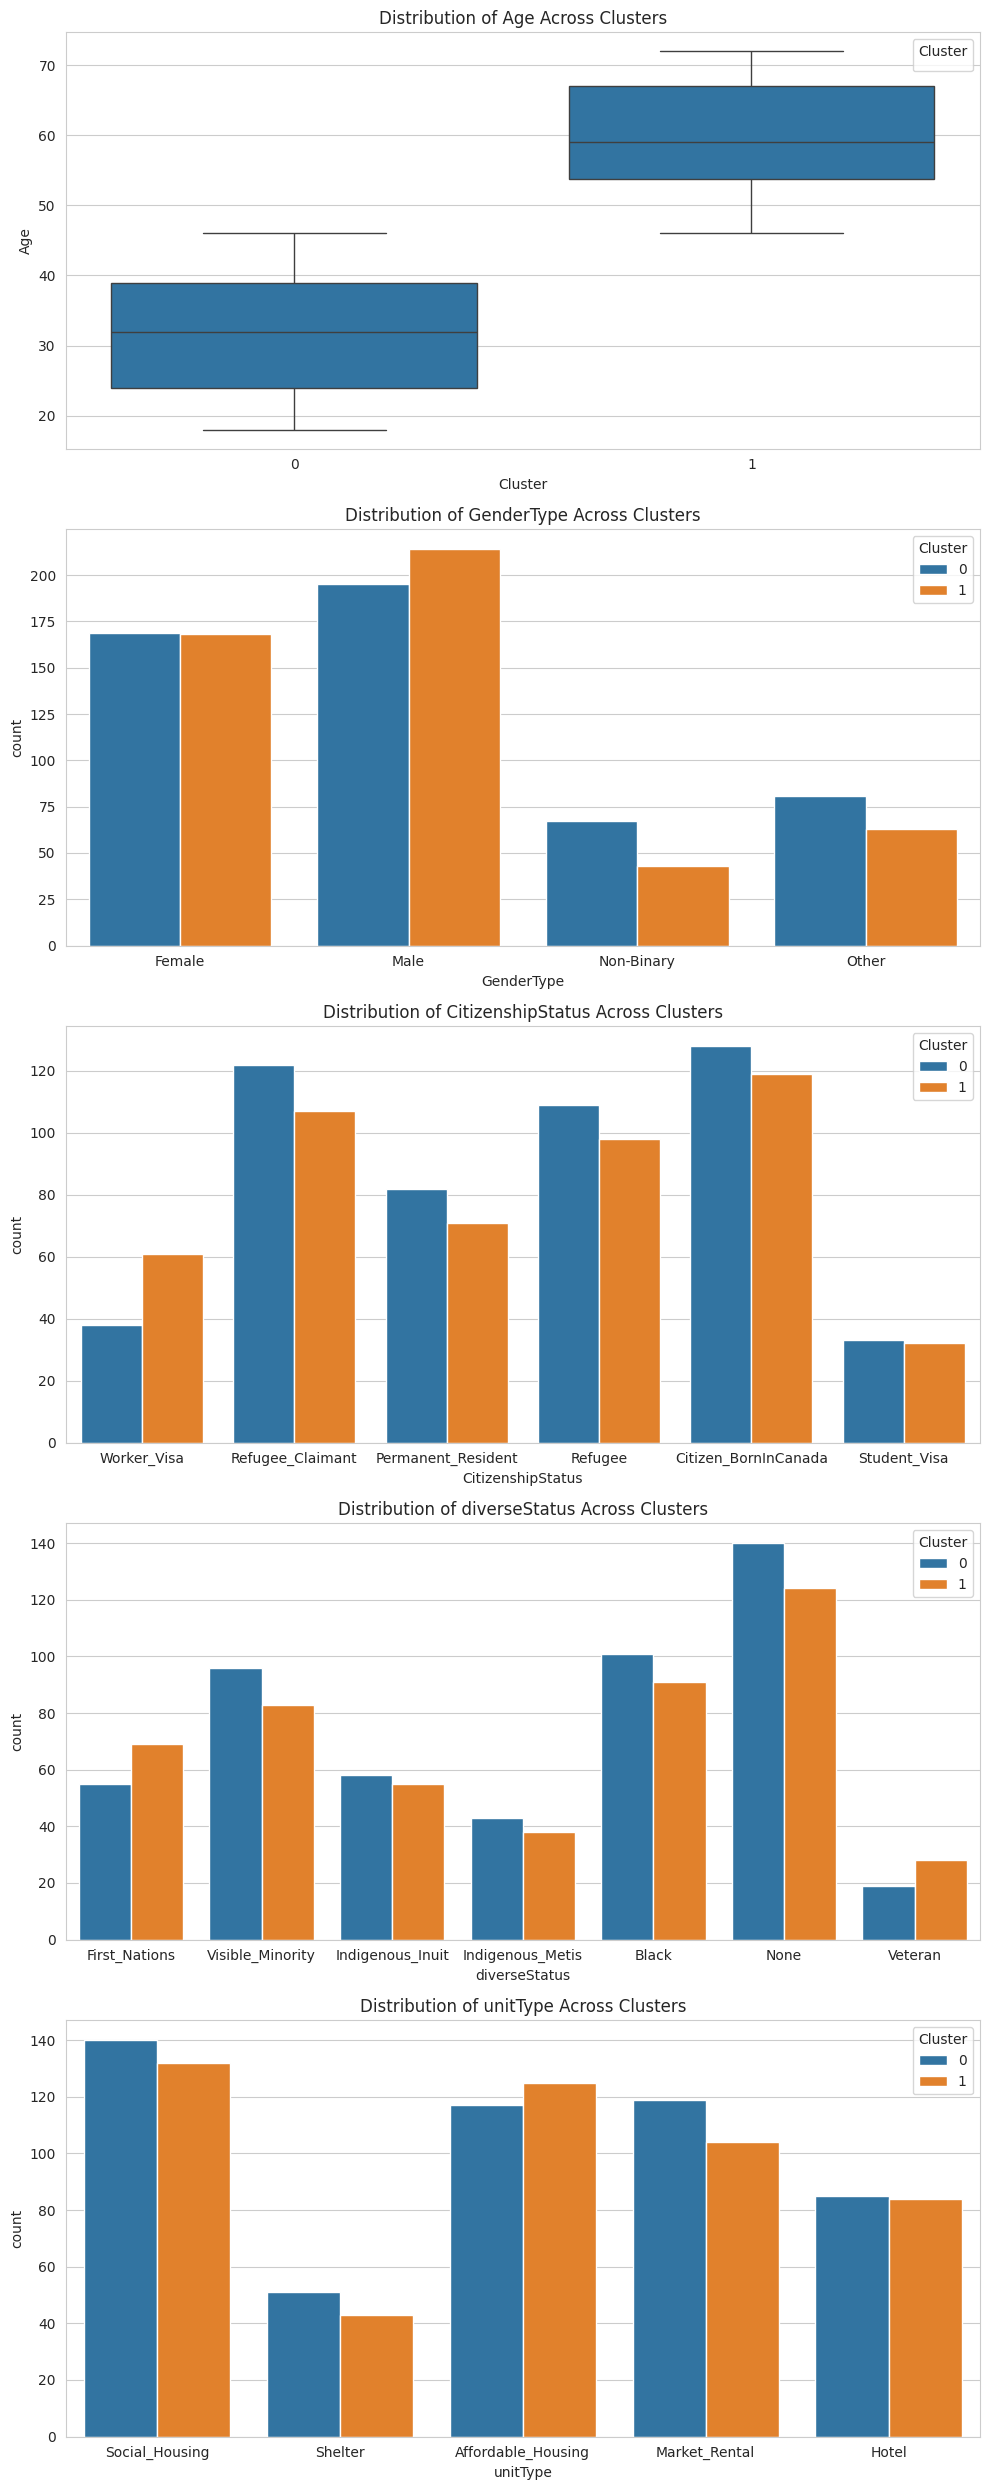

In [65]:
key_features = ['Age', 'GenderType', 'CitizenshipStatus', 'diverseStatus', 'unitType']

fig, axes = plt.subplots(len(key_features), 1, figsize=(10, 5 * len(key_features)))

for i, feature in enumerate(key_features):
    if X[feature].dtype == 'object':
        sns.countplot(data=X, x=feature, hue='Cluster', ax=axes[i])
    else:
        sns.boxplot(data=X, x='Cluster', y=feature, ax=axes[i])

    axes[i].set_title(f'Distribution of {feature} Across Clusters')
    axes[i].legend(title='Cluster')

plt.tight_layout()
plt.show()

In [66]:
selected_features = ['Age','GenderType', 'CitizenshipStatus', 'diverseStatus', 'unitType', 'numberOfBedroom', 'wheelchairAccessible', 'city', 'provience']

def summarize_numerical_data(cluster, feature):
    return X[X['Cluster'] == cluster][feature].describe()

def summarize_categorical_data(cluster, feature):
    return X[X['Cluster'] == cluster][feature].value_counts()

cluster_summaries = {}

for cluster in range(2):
    cluster_summary = {}
    for feature in selected_features:
        if X[feature].dtype == 'object':
            cluster_summary[feature] = summarize_categorical_data(cluster, feature)
        else:
            cluster_summary[feature] = summarize_numerical_data(cluster, feature)
    
    cluster_summaries[cluster] = cluster_summary


In [67]:
selected_clusters_summary_table = pd.DataFrame()

for cluster in range(2):
    for feature in selected_features:
        if feature == 'numberOfBedroom':
            value = cluster_summaries[cluster][feature].mode()[0]
        elif feature == 'Age': 
            value = cluster_summaries[cluster][feature].mean().round(1)
        elif feature == feature == 'wheelchairAccessible':
            value = cluster_summaries[cluster][feature].mode()[0]
        else:
            value = cluster_summaries[cluster][feature].idxmax()
        selected_clusters_summary_table.loc[cluster, feature] = value

selected_clusters_summary_table.index.name = 'Cluster'

selected_clusters_summary_table.rename(columns={
    'Age': "Average Age",
    'numberOfBedroom': 'Most Common Number of Bedrooms',
    'wheelchairAccessible': 'Most Common Wheelchair Accessibility',
    'city': 'Most Common City',
    'provience': 'Most Common Province'
}, inplace=True)

selected_clusters_summary_table

,Average Age,GenderType,CitizenshipStatus,diverseStatus,unitType,Most Common Number of Bedrooms,Most Common Wheelchair Accessibility,Most Common City,Most Common Province
Cluster,,,,,,,,,
0,88.9,Male,Citizen_BornInCanada,None,Social_Housing,1.0,False,Trois-Rivieres,Quebec
1,106.7,Male,Citizen_BornInCanada,None,Social_Housing,1.0,False,Fort Smith,British Columbia
